# Experiment

## Modules

In [1]:
import sys  
sys.path.insert(1, '/Users/asifahmed/Documents/Codes/MyRecourseProject')

import numpy as np
import sys
import io
import pandas as pd
from models.model_trainer import ModelTrainer
from evaluation.evaluator import Evaluator
from visualization.visualizer import Visualizer
from data_handling.dataset import Dataset
from explainability.recourse_cost_calculator import RecourseCostCalculator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from statsmodels.nonparametric.kde import KDEUnivariate

def sample_from_distribution(distribution_name, params, size=1):
    if distribution_name == 'normal':
        return np.random.normal(*params, size)
    elif distribution_name == 'uniform':
        return np.random.uniform(*params, size)
    elif distribution_name == 'power_law':
        shape, scale = params
        return (np.random.pareto(shape, size) + 1) * scale
    else:
        raise ValueError("Unsupported distribution type")

def generate_synthetic_data(n_samples=1000, seed=None, distributions=None, gender_proportions=None):
    if seed is not None:
        np.random.seed(seed)

    if gender_proportions is None:
        gender_proportions = [0.5, 0.5]

    genders = np.random.choice([1, 2], size=n_samples, p=gender_proportions)

    if distributions is None:
        raise ValueError("Distributions must be specified")

    X1, X2 = [], []
    for gender in genders:
        dists_X1 = distributions[gender]['X1']
        dists_X2 = distributions[gender]['X2']

        # Sample equally from all distributions for X1 and X2
        X1_samples = np.hstack([sample_from_distribution(dist[0], dist[1], size=n_samples//len(dists_X1)) for dist in dists_X1])
        X2_samples = np.hstack([sample_from_distribution(dist[0], dist[1], size=n_samples//len(dists_X2)) for dist in dists_X2])

        # Select one randomly for each feature
        X1.append(np.random.choice(X1_samples))
        X2.append(np.random.choice(X2_samples))
        
    X1 = np.round(X1).astype(int)
    X2 = np.round(X2).astype(int)

    noise = np.where(genders == 1, np.random.normal(0, 12, n_samples), np.random.normal(0, 15, n_samples))
    noise = np.round(noise).astype(int)    
        
    # gender_effect = np.where(genders == 1, .1, -.08)
    gender_effect = np.where(genders == 1, .1, -.08)


    decision_boundary = 0.5 * X1 + 0.3 * X2 + 0.2 * gender_effect + noise 
    y = (decision_boundary > np.median(decision_boundary)).astype(int)

    data = pd.DataFrame({'X1': X1, 'X2': X2, 'Gender': genders, 'y': y})
    data.to_csv('synthetic_data.csv', index=False)
    print("Synthetic data with bias generated and saved to 'synthetic_data.csv'.")

    return data

def load_and_preprocess_data(filepath, sample_size = 1000, target_column='y'):
    data_instance = Dataset(target_column=target_column)
    data_instance.load_csv(filepath)
    data_instance.encode_categorical_columns()
    sensitive_features = data_instance.data['Gender']
    data_instance.select_features(['y', 'X1', 'X2'])
    data_instance.sample_data(sample_size)
    return data_instance, sensitive_features

def split_and_scale_data(data_instance):
    trainer = ModelTrainer()
    X_train, X_test, y_train, y_test = trainer.split_data(data_instance.data, target_column='y')
    X_train_scaled, X_test_scaled = trainer.scale_features(X_train, X_test)
    return X_train_scaled, X_test, X_test_scaled, y_train, y_test

def train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model_type='logistic_regression'):
    trainer = ModelTrainer()
    model = trainer.train(model_type, X_train_scaled, y_train)
    evaluator = Evaluator(model, X_test_scaled, y_test)
    evaluation_report = evaluator.report()
    return model, evaluation_report

def visualize_misclassified_data(model, X_test, X_test_scaled, y_test, sensitive_features, 
                                 feature_names = ('X1', 'X2'), title='Logistic Regression Plot'):
    y_pred = model.predict(X_test_scaled)
    
    # Identify gender from sensitive features for analysis
    gender_test = sensitive_features.loc[X_test.index]
    
    # Calculate false negatives
    false_negatives = (y_test == 1) & (y_pred == 0)
    false_negative_counts = gender_test[false_negatives].value_counts()
    print("False Negative Counts by Gender:")
    print(false_negative_counts)

    # Find misclassified examples
    misclassified = y_test != y_pred
    X_misclassified = X_test_scaled[misclassified]  
    y_misclassified = y_test[misclassified]  
    gender_misclassified = gender_test[misclassified]

    # Visualize decision boundaries and misclassified points
    visualizer = Visualizer(model, X_misclassified, y_misclassified, 
                            X_original=X_test_scaled[misclassified],
                            sensitive_attr=gender_misclassified)
    visualizer.plot_decision_boundary_interactive(feature_names, title)

def get_false_negatives(model,X_test, X_test_scaled, y_test, sensitive_features):
    y_pred = model.predict(X_test_scaled)
    gender_test = sensitive_features[X_test.index]
    false_negatives = (y_test == 1) & (y_pred == 0)
    false_negative_counts = gender_test[false_negatives].value_counts()
    return false_negatives, false_negative_counts

def identify_false_negatives(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    false_negatives = (y_test == 1) & (y_pred == 0)
    X_false_negatives = X_test_scaled[false_negatives]
    y_false_negatives = y_test[false_negatives]
    
    return X_false_negatives, y_false_negatives, false_negatives

def rank_false_negatives_by_recourse(model, X_false_negatives, y_false_negatives, sensitive_features):
    sensitive_features_aligned = sensitive_features.reindex(y_false_negatives.index)
    gender_false_negatives = sensitive_features_aligned
    recourse_calculator = RecourseCostCalculator(model)
    recourse_without_rewards = recourse_calculator.rank_data_points(X_false_negatives, gender_data=gender_false_negatives)
    return recourse_without_rewards, gender_false_negatives

def remove_female_data_points_below_median(recourse_df):
    median_recourse = recourse_df[recourse_df['Gender'] == 2]['Recourse Cost'].median()
    below_median_females = (recourse_df['Gender'] == 2) & (recourse_df['Recourse Cost'] < median_recourse)
    n_removed = below_median_females.sum()
    recourse_df_filtered = recourse_df[~below_median_females].reset_index(drop=True)
    return recourse_df_filtered, n_removed

def remove_lowest_recourse_females(recourse_df, percentile=10):
    threshold = np.percentile(recourse_df[recourse_df['Gender'] == 2]['Recourse Cost'], percentile)
    close_females = (recourse_df['Gender'] == 2) & (recourse_df['Recourse Cost'] <= threshold)
    n_removed = close_females.sum()
    recourse_df_filtered = recourse_df[~close_females].reset_index(drop=True)
    return recourse_df_filtered, n_removed

def identify_females_to_help(recourse_without_rewards, percentage_to_help):
    recourse_calculator = RecourseCostCalculator(None)  # Assuming the model isn't needed here
    females_to_help = recourse_calculator.identify_females_to_help(recourse=recourse_without_rewards, percentage_to_help=percentage_to_help)
    females_to_help_indices = females_to_help['Index']
    condition = ((recourse_without_rewards['Gender'] == 1) | 
                 (recourse_without_rewards['Index'].isin(females_to_help_indices)))  # Keep selected females
    recourse_without_unwanted_females = recourse_without_rewards[condition]
    return recourse_without_unwanted_females

def apply_gender_rewards_and_rank(model, recourse_without_rewards, top_k=10):
    recourse_calculator = RecourseCostCalculator(model)
    recourse_with_rewards = recourse_calculator.apply_gender_rewards(recourse_without_rewards)
    return recourse_with_rewards

def generate_female_data_points(model, recourse_without_rewards_filtered, n_removed, x1_range=(-1, 1)):
    female_recourse_values = recourse_without_rewards_filtered[recourse_without_rewards_filtered['Gender'] == 2]['Recourse Cost']
    min_recourse = female_recourse_values.min()
    max_recourse = female_recourse_values.max()

    random_recourse_values = np.random.uniform(min_recourse, max_recourse, n_removed)

    new_data_points = []

    start_index = recourse_without_rewards_filtered['Index'].max() + 1

    for i, recourse in enumerate(random_recourse_values):
        while True:  
            weights = model.coef_[0]
            intercept = model.intercept_[0]
            direction = weights / np.linalg.norm(weights)

            x1 = np.random.uniform(x1_range[0], x1_range[1])
            x2 = -(intercept + weights[0] * x1) / weights[1]  
            point_on_boundary = np.array([x1, x2])

            original_point = point_on_boundary - recourse * direction

            # Check if the generated point is in the negative region
            decision_score = np.dot(weights, original_point) + intercept
            if decision_score < 0:
                break 

        new_data_points.append({
            'Index': start_index + i,
            'Feature1': original_point[0],
            'Feature2': original_point[1],
            'Gender': 2,
            'Rank': len(recourse_without_rewards_filtered) + i + 1,  # Assigning rank as the next available rank
            'Recourse Cost': recourse
        })

    new_data_df = pd.DataFrame(new_data_points)
    
    return new_data_df

def plot_custom_grid_of_histograms(top_k_before_after, top_k_male_list, top_k_female_list, titles, figsize=(30,20)):
    fig, axs = plt.subplots(4, 6, figsize=figsize)

    all_data = np.concatenate([df['Recourse Cost'] for df in top_k_before_after + top_k_male_list + top_k_female_list])
    x_min = np.min(all_data)
    x_max = np.max(all_data)
    y_max = max([df['Recourse Cost'].value_counts().max() for df in top_k_before_after + top_k_male_list + top_k_female_list])

    for i in range(6):
        for j, dataset in enumerate([top_k_before_after, top_k_male_list, top_k_female_list]):
            data = dataset[i]['Recourse Cost']
            ax = axs[j, i]
            sns.histplot(data, kde=True, ax=ax, color=['blue', 'green', 'red'][j], bins=10)
            ax.set_title(titles[j * 6 + i])
            ax.set_xlim(x_min, x_max) 
            ax.set_ylim(0, y_max * 1.1)

    for i in range(6):
        ax_pie = axs[3, i]  # Fourth row, position corresponds to the histogram above
        gender_counts = top_k_before_after[i]['Gender'].value_counts()
        labels = ['Males' if idx == 1 else 'Females' for idx in gender_counts.index]
        colors = ['#1f77b4' if label == 'Males' else '#ff7f0e' for label in labels]
        ax_pie.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
        ax_pie.set_title(titles[i] + ' - Gender Dist')

    plt.tight_layout()
    plt.show()

def experiment(params):
    buffer = io.StringIO()
    old_stdout = sys.stdout
    sys.stdout = buffer 

    dataset_size = params['dataset_size']
    sample_size = params['sample_size']
    model_type = params['model_type']
    percentage_to_help = params['percentage_to_help']
    top_k = int(sample_size / 100) 
    filepath = params['filepath']
    distributions = params['distributions']
    gender_proportions = params['gender_proportions']

    # Generate synthetic data and preprocess it
    data = generate_synthetic_data(dataset_size, distributions=distributions, gender_proportions=gender_proportions)
    data_instance, sensitive_features = load_and_preprocess_data(filepath=filepath, sample_size=sample_size)

    X_train_scaled, X_test, X_test_scaled, y_train, y_test = split_and_scale_data(data_instance=data_instance)
    model, evaluation_report = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model_type=model_type)

    # Identify false negatives and rank them
    X_false_negatives, y_false_negatives, false_negatives = identify_false_negatives(model, X_test_scaled, y_test)
    recourse_without_rewards, gender_false_negatives = rank_false_negatives_by_recourse(model, X_false_negatives, y_false_negatives, sensitive_features)

    # Count females in the top k before removing and adding data points
    top_k_before_changes = recourse_without_rewards.head(top_k)
    female_count_before_changes = top_k_before_changes[top_k_before_changes['Gender'] == 2].shape[0]

    # Remove female data points below the median and generate new points
    recourse_without_rewards_filtered, n_removed = remove_female_data_points_below_median(recourse_without_rewards)
    new_female_data_points = generate_female_data_points(model, recourse_without_rewards_filtered, n_removed)
    
    # Concatenate new points with the existing ones and sort by recourse
    combined_df = pd.concat([recourse_without_rewards_filtered, new_female_data_points], ignore_index=True)
    combined_df_sorted = combined_df.sort_values(by='Recourse Cost').reset_index(drop=True)
    combined_df_sorted['Recourse Cost'] = combined_df_sorted['Recourse Cost'].round(2)
    combined_df_sorted['Rank'] = combined_df_sorted.index + 1

    # Count females in the top k after removing and adding data points
    top_k_after_changes = combined_df_sorted.head(top_k)
    female_count_after_changes = top_k_after_changes[top_k_after_changes['Gender'] == 2].shape[0]

    # Apply rewards
    recourse_with_rewards = apply_gender_rewards_and_rank(model, combined_df_sorted, top_k=top_k)

    sys.stdout = old_stdout
    captured_output = buffer.getvalue()

    print("Experiment completed with captured output:")
    print(captured_output)
    
    print(f"Number of females in top {top_k} before removing and adding: {female_count_before_changes}")
    print(f"Number of females in top {top_k} after removing and adding: {female_count_after_changes}\n")

    return combined_df_sorted, recourse_with_rewards

## Experiment 1

Only the sample size is changed in this experiment. In this experiment, we observed how changing the sample size affects the top k data distribution.

Experiment completed with captured output:
Synthetic data with bias generated and saved to 'synthetic_data.csv'.
CSV file loaded successfully with delimiter: ','
Selected features are now active: ['y', 'X1', 'X2']
Data has been sampled. New data size: 1000 rows.
Data split into train and test sets.
logistic_regression model trained successfully.
Accuracy: 0.615
Precision: 0.5757575757575758
Recall: 0.6195652173913043
F1 Score: 0.5968586387434555
Confusion Matrix:
 [[66 42]
 [35 57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63       108
           1       0.58      0.62      0.60        92

    accuracy                           0.61       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.62      0.61      0.62       200


Number of females in top 10 before removing and adding: 4
Number of females in top 10 after removing and adding: 1

Experiment completed with captured output:
S

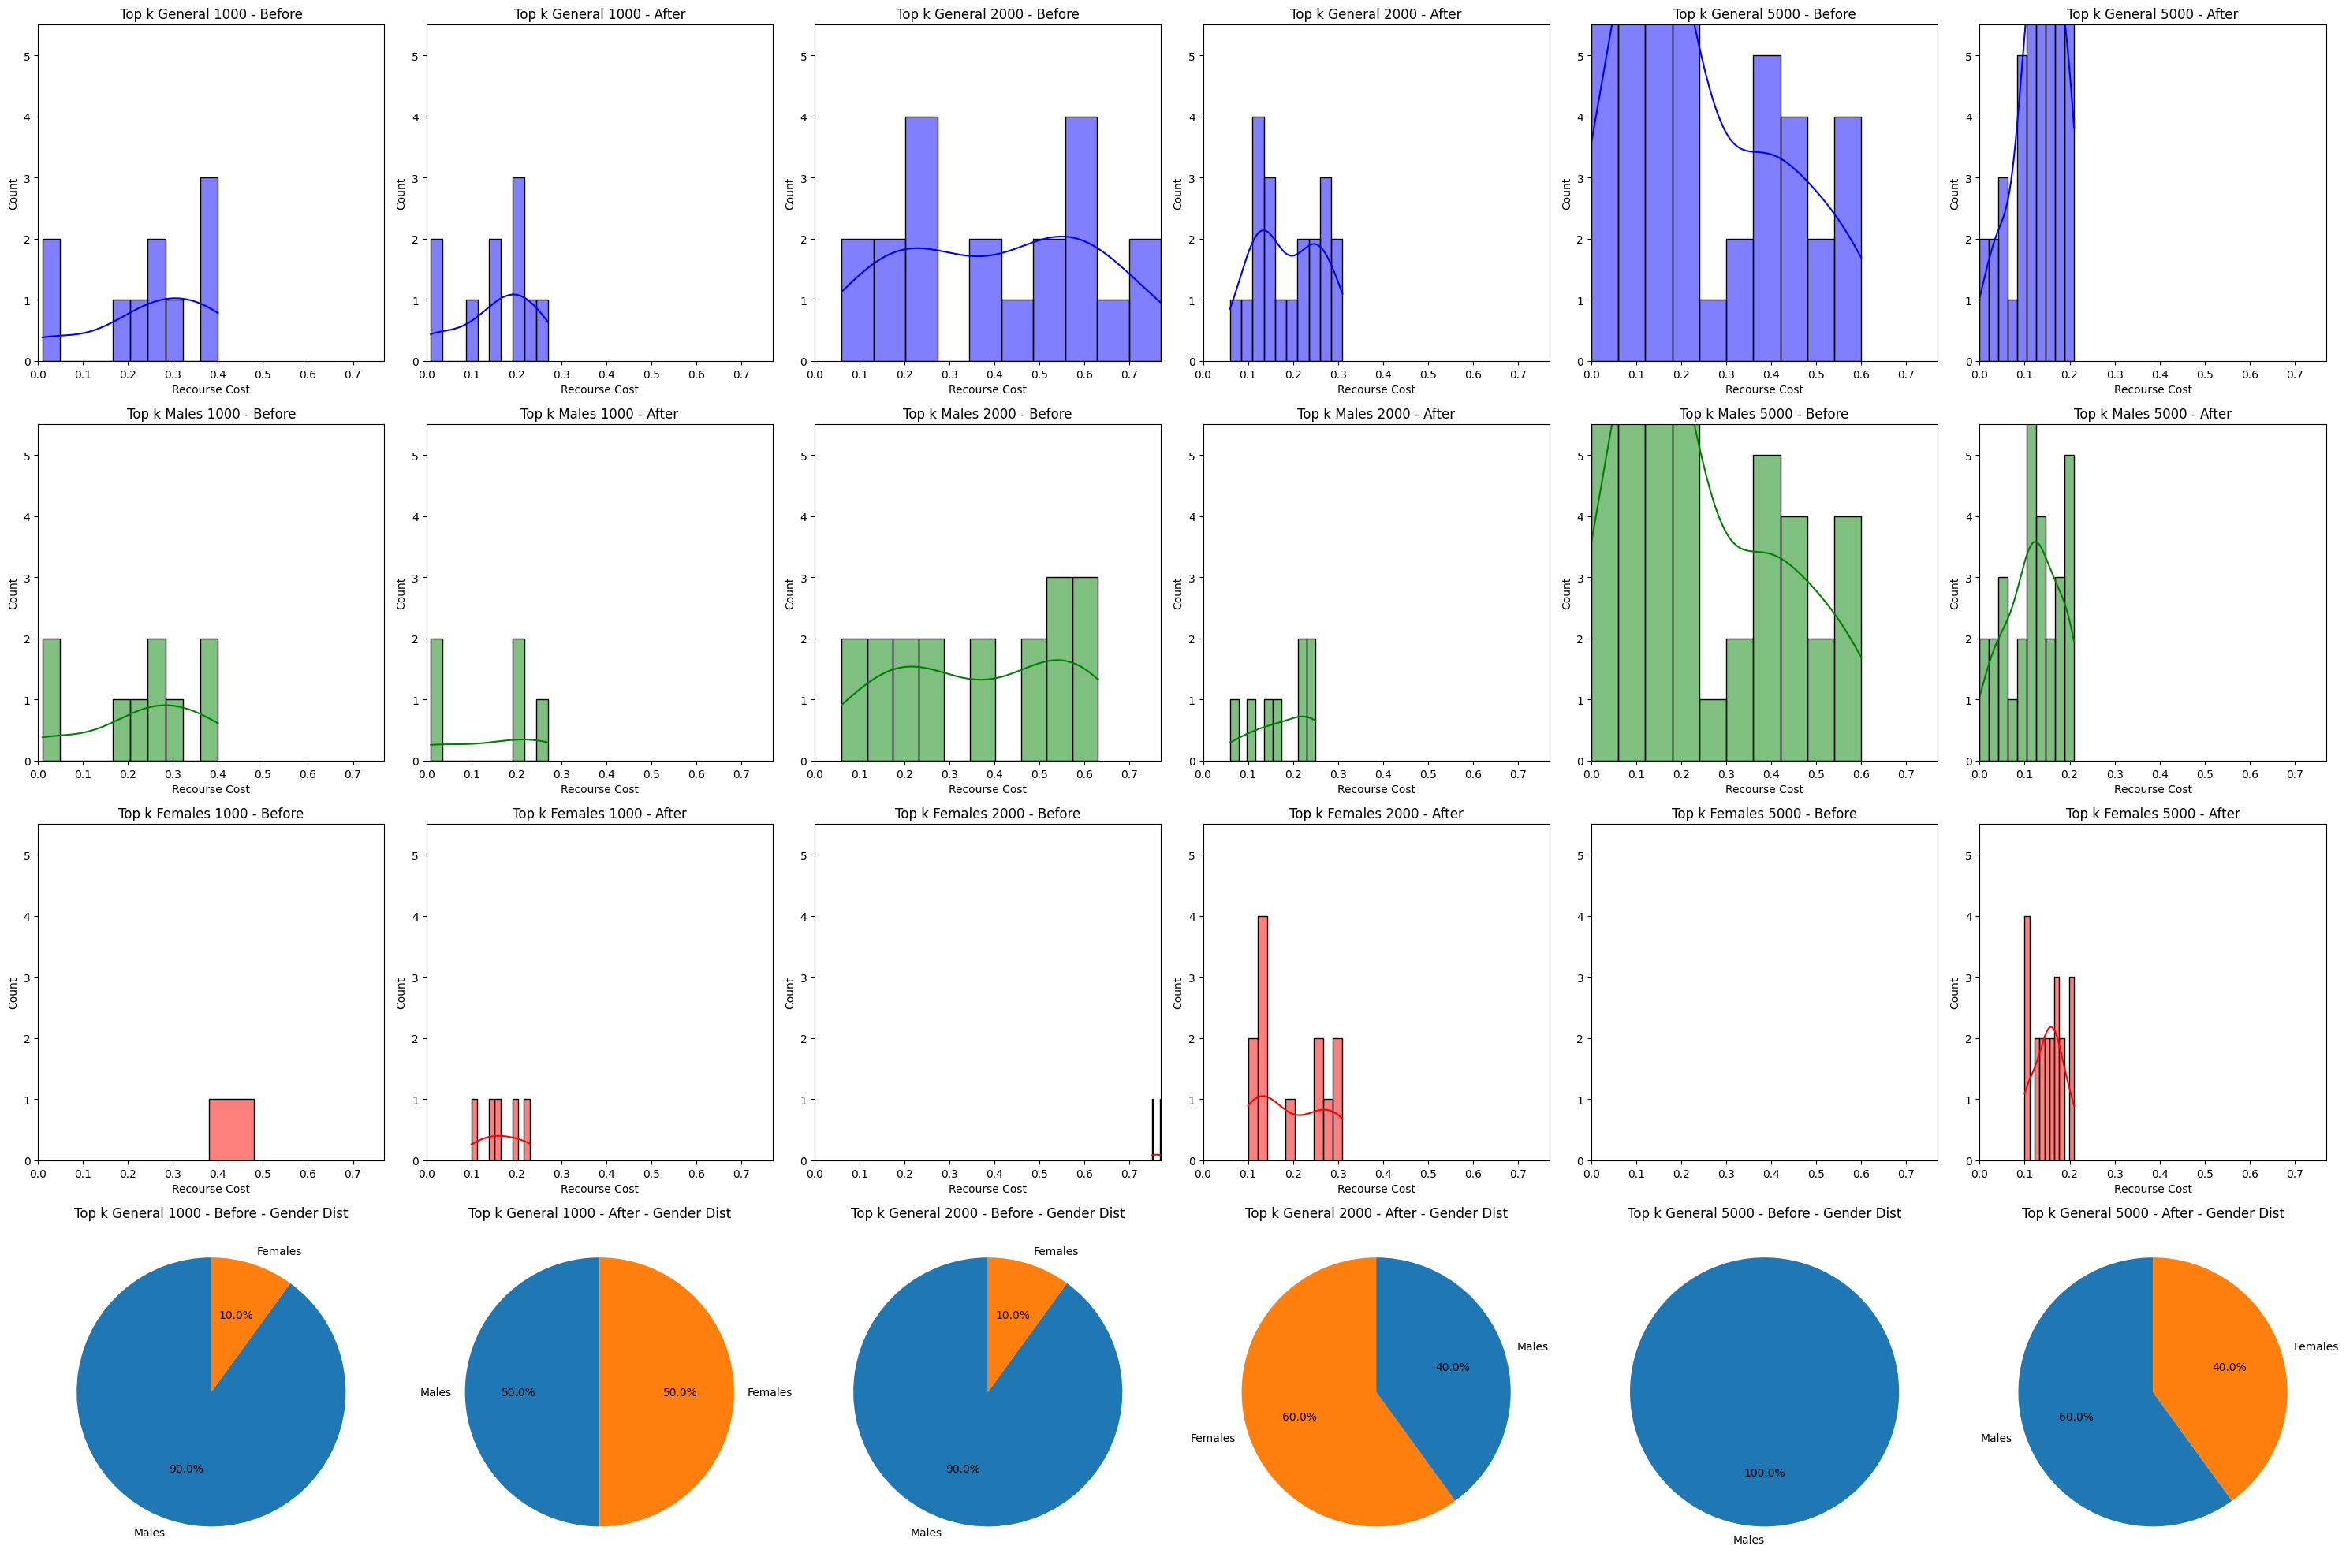

In [2]:
import itertools

distributions1 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('uniform', (30, 60))], 'X2': [('normal', (55, 10))]}   # Female distributions
}

gender_proportions = [0.6, 0.4]

param_grid = {
    'dataset_size': [10000],
    'distributions': [distributions1],  
    'sample_size': [1000,2000,5000],
    'model_type': ['logistic_regression'],
    'percentage_to_help': [0.5],
    'top_k': [10],
    'filepath': ['synthetic_data.csv'],
    'gender_proportions': [gender_proportions]  
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

recourse_without_rewards_list = []
recourse_with_rewards_list = []
top_k_before_after = []
top_k_male_list = []
top_k_female_list = []
top_k_male_before_after = []
top_k_female_before_after = []
male_female_counts_before_after = []

for params in all_params:
    recourse_without_rewards, recourse_with_rewards = experiment(params)

    # print("\nRecourse Without Rewards DataFrame:")
    # print(recourse_without_rewards)

    # print("\nRecourse With Rewards DataFrame:")
    # print(recourse_with_rewards)
    
    top_k = int(params['sample_size']/100)

    top_k_before_rewards = recourse_without_rewards.head(top_k)
    top_k_after_rewards = recourse_with_rewards.head(top_k)

    top_k_before_after.append(top_k_before_rewards)
    top_k_before_after.append(top_k_after_rewards)

    top_k_males_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 1]
    top_k_females_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 2]
    top_k_males_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 1]
    top_k_females_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 2]

    top_k_male_before_after.append(top_k_males_before)
    top_k_male_before_after.append(top_k_males_after)

    top_k_female_before_after.append(top_k_females_before)
    top_k_female_before_after.append(top_k_females_after)
    
    male_female_counts_before_after.append((len(top_k_males_before), len(top_k_females_before)))
    male_female_counts_before_after.append((len(top_k_males_after), len(top_k_females_after)))


titles = [
    "Top k General 1000 - Before", "Top k General 1000 - After",
    "Top k General 2000 - Before", "Top k General 2000 - After",
    "Top k General 5000 - Before", "Top k General 5000 - After",
    "Top k Males 1000 - Before", "Top k Males 1000 - After",
    "Top k Males 2000 - Before", "Top k Males 2000 - After",
    "Top k Males 5000 - Before", "Top k Males 5000 - After",
    "Top k Females 1000 - Before", "Top k Females 1000 - After",
    "Top k Females 2000 - Before", "Top k Females 2000 - After",
    "Top k Females 5000 - Before", "Top k Females 5000 - After"
]

plot_custom_grid_of_histograms(top_k_before_after, top_k_male_before_after, top_k_female_before_after, titles)

## Experiment 2

Here, we are changing the original data distribution of X1 for female, and observing the top k data distribution. 

1. Uniform.
2. Normal. 
3. Power law.

Experiment completed with captured output:
Synthetic data with bias generated and saved to 'synthetic_data.csv'.
CSV file loaded successfully with delimiter: ','
Selected features are now active: ['y', 'X1', 'X2']
Data has been sampled. New data size: 1000 rows.
Data split into train and test sets.
logistic_regression model trained successfully.
Accuracy: 0.7
Precision: 0.7307692307692307
Recall: 0.59375
F1 Score: 0.6551724137931034
Confusion Matrix:
 [[83 21]
 [39 57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.80      0.73       104
           1       0.73      0.59      0.66        96

    accuracy                           0.70       200
   macro avg       0.71      0.70      0.69       200
weighted avg       0.70      0.70      0.70       200


Number of females in top 10 before removing and adding: 4
Number of females in top 10 after removing and adding: 0

Experiment completed with captured output:
Synthetic data

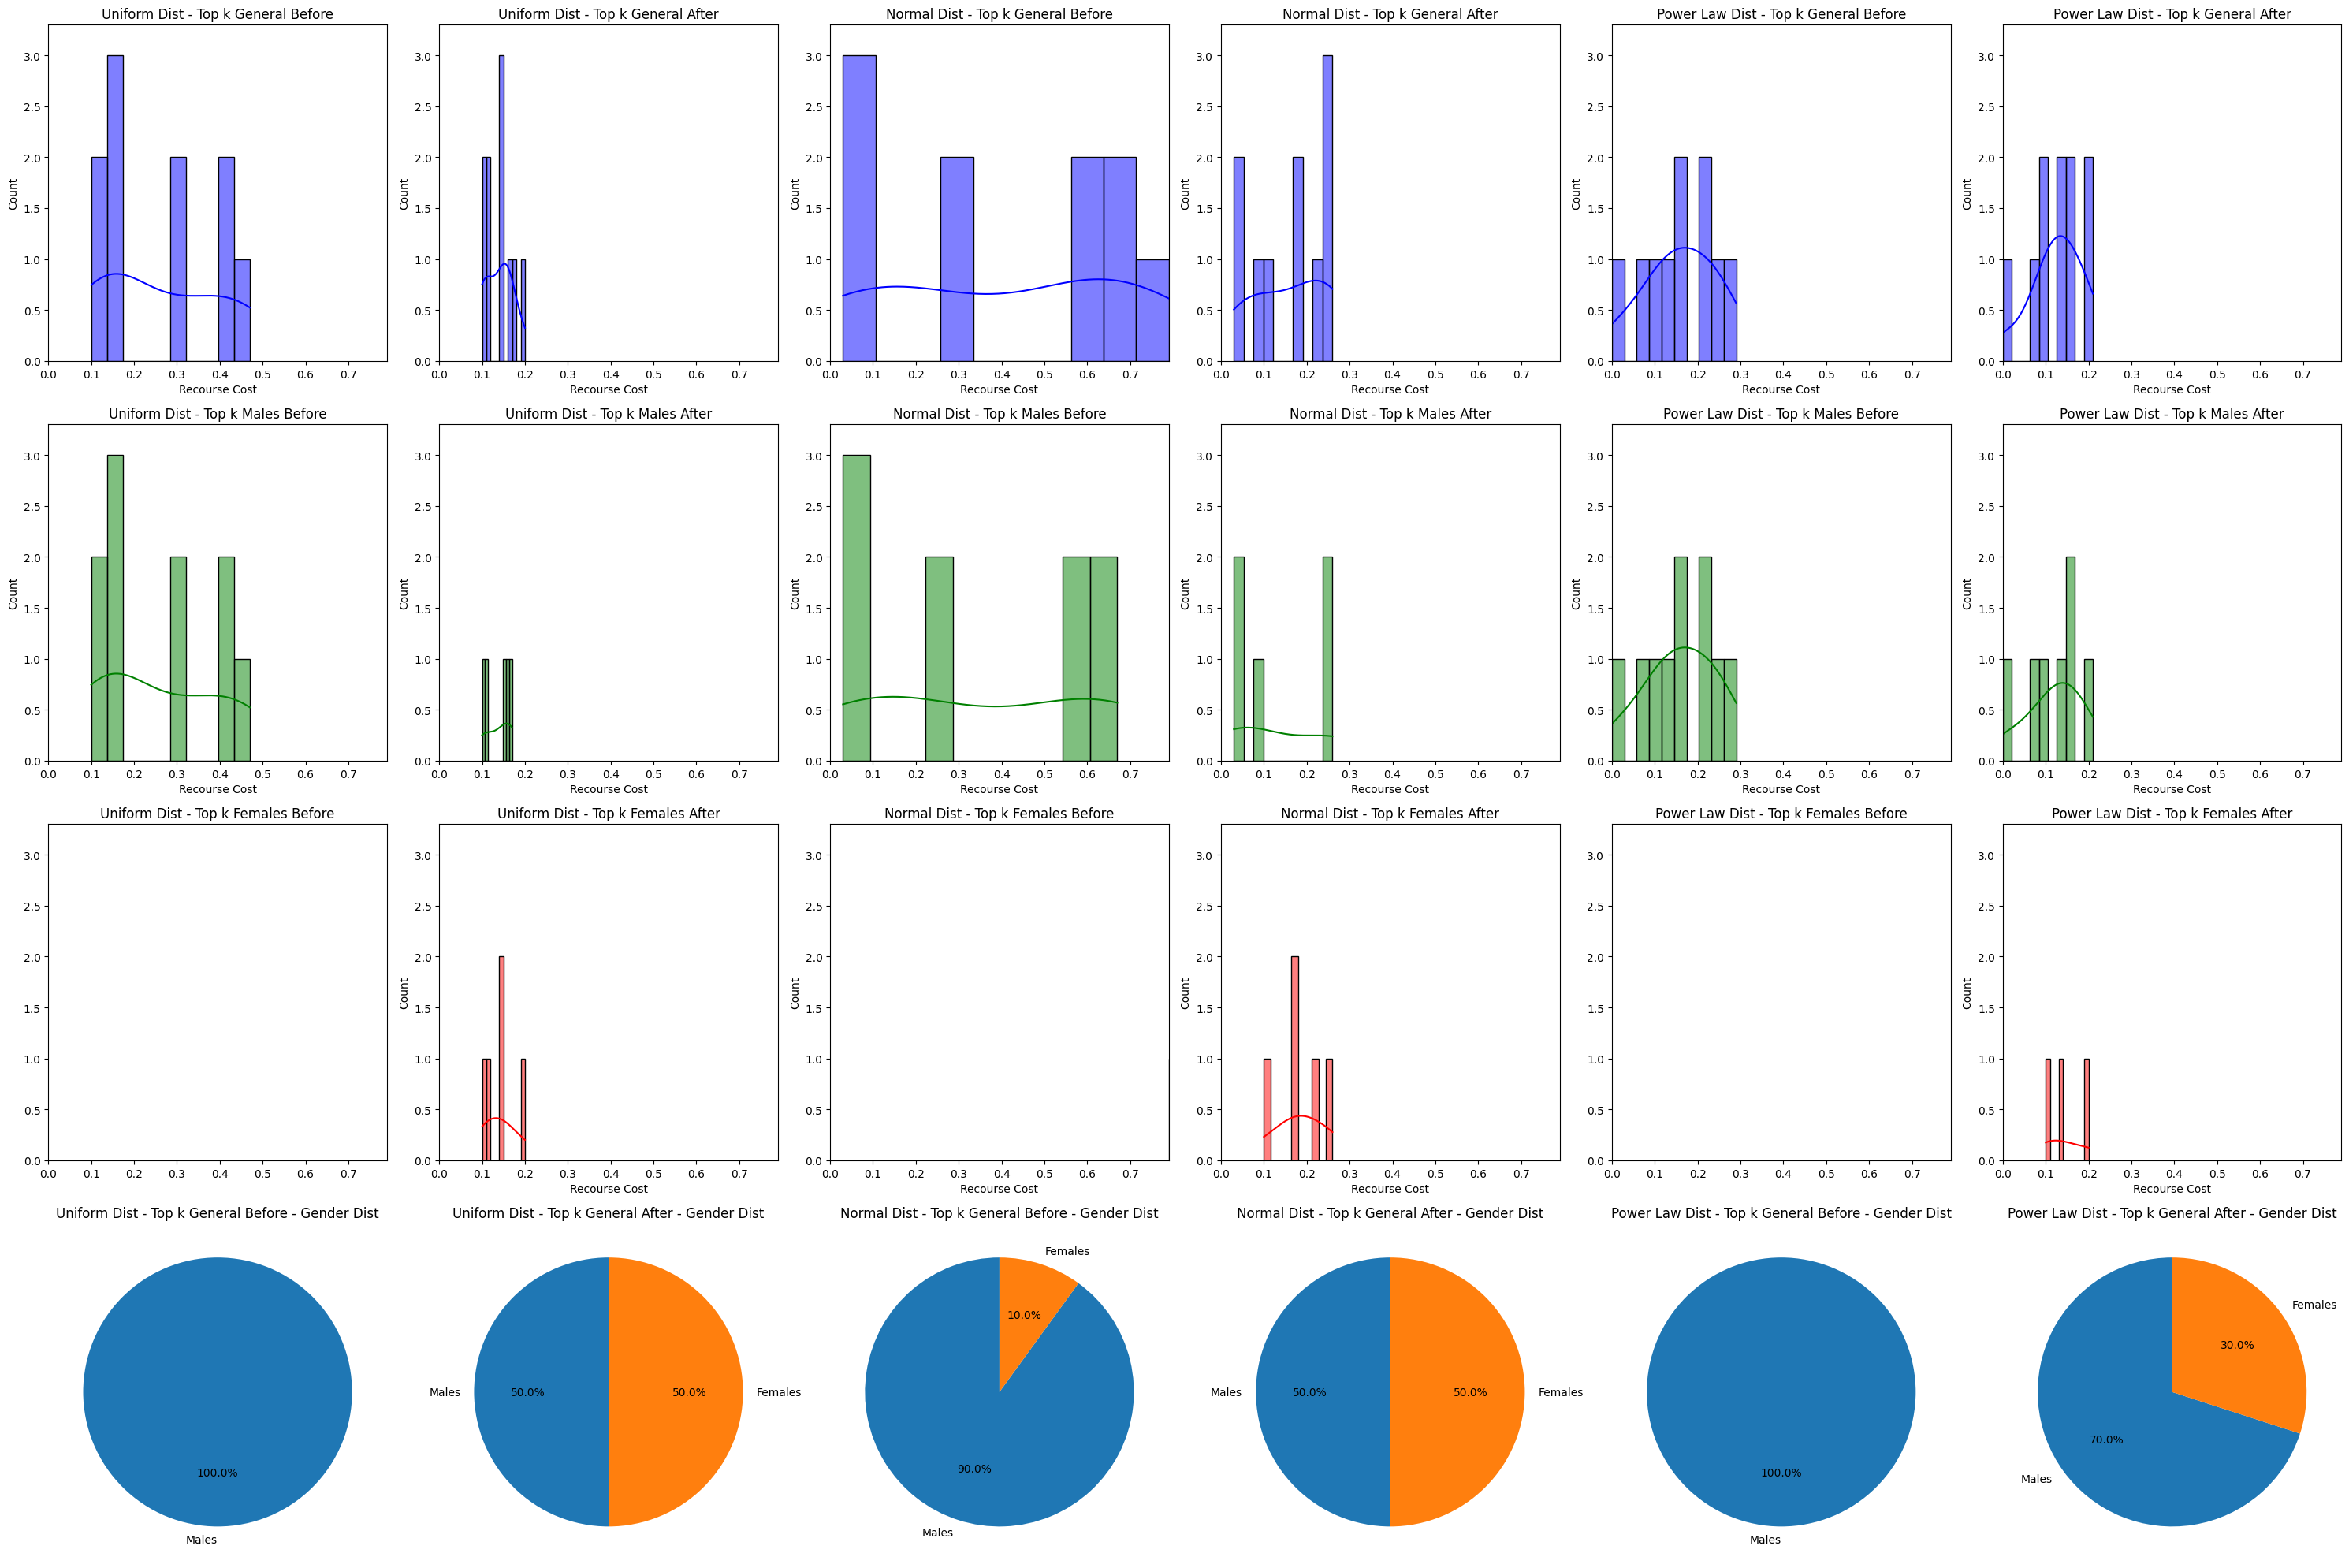

In [6]:
import itertools

distributions1 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('uniform', (30, 60))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

distributions2 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('normal', (30, 10))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

distributions3 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('power_law', (3, 30))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

gender_proportions = [0.6, 0.4]

param_grid = {
    'dataset_size': [10000],
    'distributions': [distributions1, distributions2, distributions3],  
    'sample_size': [1000],
    'model_type': ['logistic_regression'],
    'percentage_to_help': [0.5],
    'top_k': [10],
    'filepath': ['synthetic_data.csv'],
    'gender_proportions': [gender_proportions]  
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

recourse_without_rewards_list = []
recourse_with_rewards_list = []
top_k_before_after = []
top_k_male_list = []
top_k_female_list = []
top_k_male_before_after = []
top_k_female_before_after = []
male_female_counts_before_after = []

for params in all_params:
    recourse_without_rewards, recourse_with_rewards = experiment(params)

    top_k = int(params['sample_size']/100)

    top_k_before_rewards = recourse_without_rewards.head(top_k)
    top_k_after_rewards = recourse_with_rewards.head(top_k)

    top_k_before_after.append(top_k_before_rewards)
    top_k_before_after.append(top_k_after_rewards)

    top_k_males_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 1]
    top_k_females_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 2]
    top_k_males_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 1]
    top_k_females_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 2]

    top_k_male_before_after.append(top_k_males_before)
    top_k_male_before_after.append(top_k_males_after)

    top_k_female_before_after.append(top_k_females_before)
    top_k_female_before_after.append(top_k_females_after)
    
    male_female_counts_before_after.append((len(top_k_males_before), len(top_k_females_before)))
    male_female_counts_before_after.append((len(top_k_males_after), len(top_k_females_after)))

titles = [
    "Uniform Dist - Top k General Before", "Uniform Dist - Top k General After",
    "Normal Dist - Top k General Before", "Normal Dist - Top k General After",
    "Power Law Dist - Top k General Before", "Power Law Dist - Top k General After",
    "Uniform Dist - Top k Males Before", "Uniform Dist - Top k Males After",
    "Normal Dist - Top k Males Before", "Normal Dist - Top k Males After",
    "Power Law Dist - Top k Males Before", "Power Law Dist - Top k Males After",
    "Uniform Dist - Top k Females Before", "Uniform Dist - Top k Females After",
    "Normal Dist - Top k Females Before", "Normal Dist - Top k Females After",
    "Power Law Dist - Top k Females Before", "Power Law Dist - Top k Females After"
]

plot_custom_grid_of_histograms(top_k_before_after, top_k_male_before_after, top_k_female_before_after, titles)



## Experminet 3

In this experiment, we are observing what happenes if female has multiple normal distributions. So, we observing,

1. One normal distributions
2. Two normal distributions
3. Three normal distributions

Experiment completed with captured output:
Synthetic data with bias generated and saved to 'synthetic_data.csv'.
CSV file loaded successfully with delimiter: ','
Selected features are now active: ['y', 'X1', 'X2']
Data has been sampled. New data size: 1000 rows.
Data split into train and test sets.
logistic_regression model trained successfully.
Accuracy: 0.695
Precision: 0.6836734693877551
Recall: 0.6907216494845361
F1 Score: 0.6871794871794872
Confusion Matrix:
 [[72 31]
 [30 67]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70       103
           1       0.68      0.69      0.69        97

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.70      0.69      0.70       200


Number of females in top 10 before removing and adding: 2
Number of females in top 10 after removing and adding: 0

Experiment completed with captured output:
S

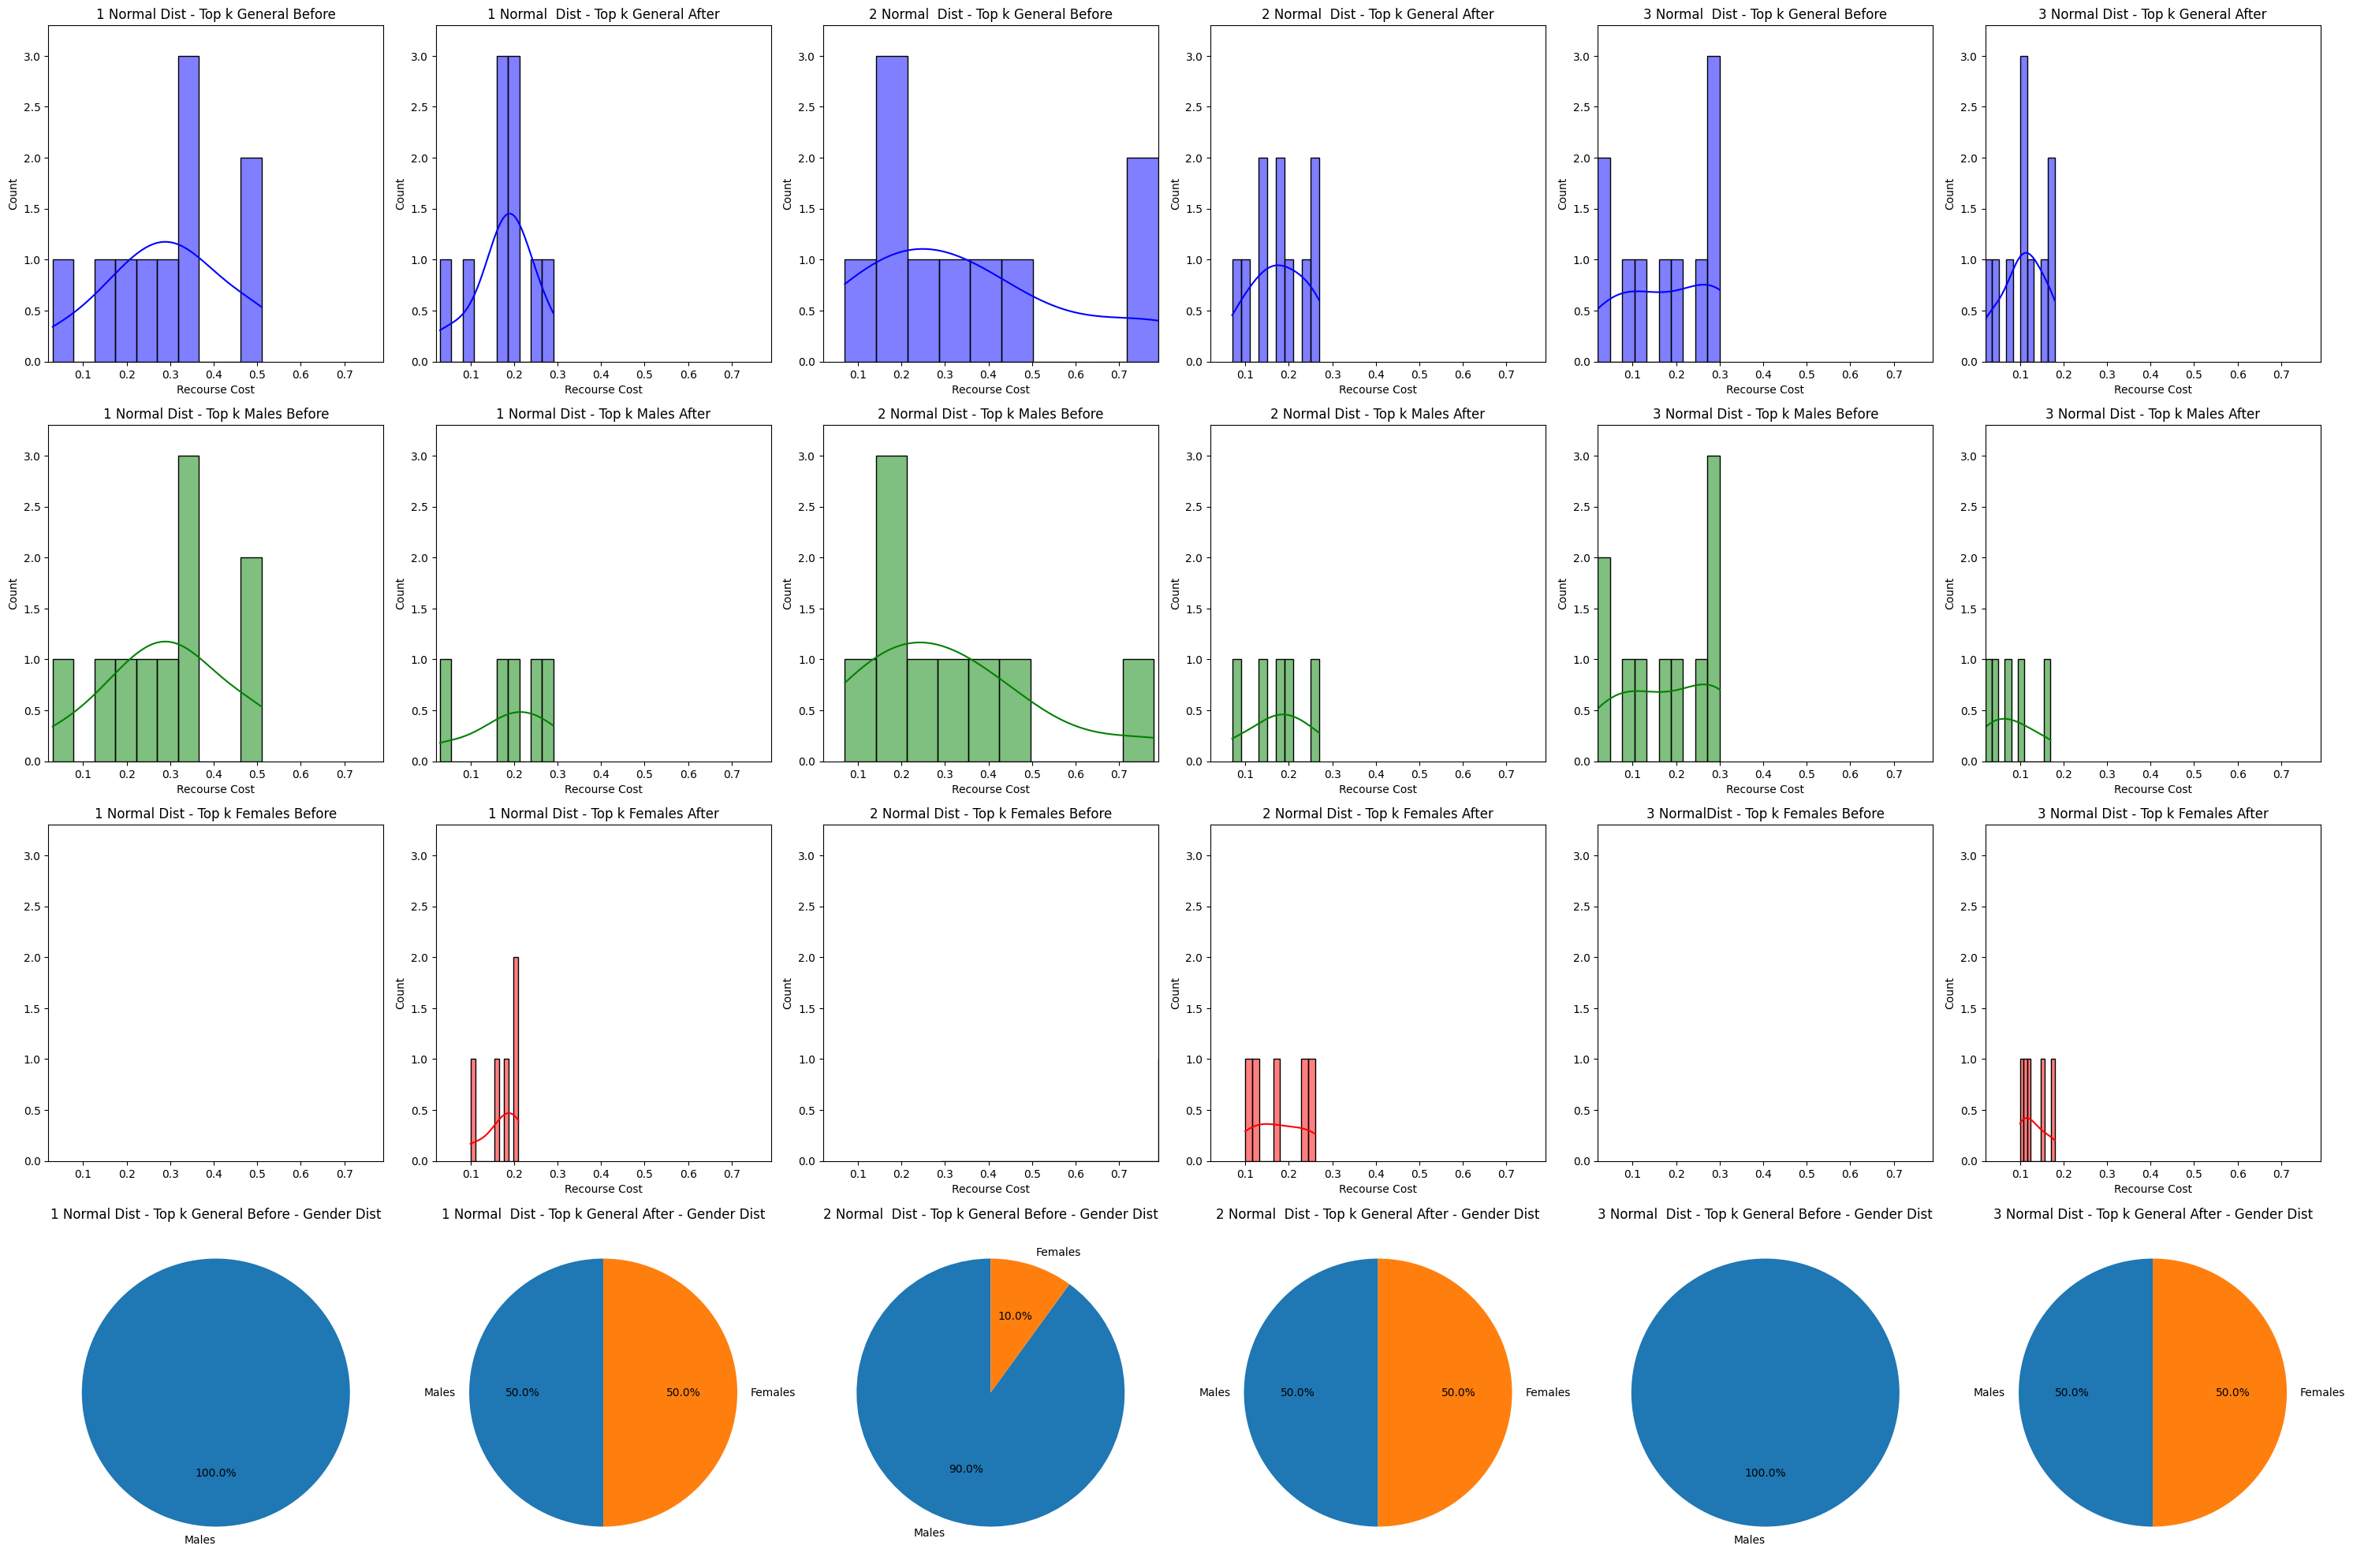

In [5]:
import itertools

distributions1 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('normal', (30, 10))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

distributions2 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('normal', (30, 10)), ('normal', (50, 10))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

distributions3 = {
    1: {'X1': [('uniform', (40, 70))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('normal', (30, 10)), ('normal', (50, 10)), ('normal', (60, 10))], 'X2': [('normal', (55, 15))]}   # Female distributions
}

gender_proportions = [0.6, 0.4]

param_grid = {
    'dataset_size': [10000],
    'distributions': [distributions1, distributions2, distributions3],  
    'sample_size': [1000],
    'model_type': ['logistic_regression'],
    'percentage_to_help': [0.5],
    'top_k': [10],
    'filepath': ['synthetic_data.csv'],
    'gender_proportions': [gender_proportions]  
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

recourse_without_rewards_list = []
recourse_with_rewards_list = []
top_k_before_after = []
top_k_male_list = []
top_k_female_list = []
top_k_male_before_after = []
top_k_female_before_after = []
male_female_counts_before_after = []

for params in all_params:
    recourse_without_rewards, recourse_with_rewards = experiment(params)

    # print("\nRecourse Without Rewards DataFrame:")
    # print(recourse_without_rewards)

    # print("\nRecourse With Rewards DataFrame:")
    # print(recourse_with_rewards)

    top_k = int(params['sample_size']/100)

    top_k_before_rewards = recourse_without_rewards.head(top_k)
    top_k_after_rewards = recourse_with_rewards.head(top_k)

    top_k_before_after.append(top_k_before_rewards)
    top_k_before_after.append(top_k_after_rewards)

    top_k_males_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 1]
    top_k_females_before = top_k_before_rewards[top_k_before_rewards['Gender'] == 2]
    top_k_males_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 1]
    top_k_females_after = top_k_after_rewards[top_k_after_rewards['Gender'] == 2]

    top_k_male_before_after.append(top_k_males_before)
    top_k_male_before_after.append(top_k_males_after)

    top_k_female_before_after.append(top_k_females_before)
    top_k_female_before_after.append(top_k_females_after)
    
    male_female_counts_before_after.append((len(top_k_males_before), len(top_k_females_before)))
    male_female_counts_before_after.append((len(top_k_males_after), len(top_k_females_after)))

titles = [
    "1 Normal Dist - Top k General Before", "1 Normal  Dist - Top k General After",
    "2 Normal  Dist - Top k General Before", "2 Normal  Dist - Top k General After",
    "3 Normal  Dist - Top k General Before", "3 Normal Dist - Top k General After",
    "1 Normal Dist - Top k Males Before", "1 Normal Dist - Top k Males After",
    "2 Normal Dist - Top k Males Before", "2 Normal Dist - Top k Males After",
    "3 Normal Dist - Top k Males Before", "3 Normal Dist - Top k Males After",
    "1 Normal Dist - Top k Females Before", "1 Normal Dist - Top k Females After",
    "2 Normal Dist - Top k Females Before", "2 Normal Dist - Top k Females After",
    "3 NormalDist - Top k Females Before", "3 Normal Dist - Top k Females After"
]

plot_custom_grid_of_histograms(top_k_before_after, top_k_male_before_after, top_k_female_before_after, titles)